In [1]:
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Loading
X_model = pd.read_csv('X_model.csv')
Y_model = pd.read_csv('Y_model.csv')
# Define preprocessors
def preprocess(X: pd.DataFrame):
    X = X.fillna(0)
    # Create new dataframe from columns "gender", "age_code", and "region_code"
    X_new = pd.DataFrame(X, columns=['gender', 'age_code', 'region_code'])
    GIT_range = r"202205[0-9]{2}"
    cGIT = np.sum(X.filter(regex=("c" + GIT_range), axis=1).values, axis=1)
    tGIT = np.sum(X.filter(regex=("t" + GIT_range), axis=1).values, axis=1)
    sGIT = np.sum(X.filter(regex=("s" + GIT_range), axis=1).values, axis=1)

    VAT_range = r"20220[17](?:[01][0-9]|2[0-5])"
    tVAT = np.sum(X.filter(regex=("t" + VAT_range), axis=1).values, axis=1)
    sVAT = np.sum(X.filter(regex=("s" + VAT_range), axis=1).values, axis=1)

    entire_range = r"2022[0-9]{4}"
    cEntire = np.sum(X.filter(regex=("c" + entire_range), axis=1).values, axis=1)
    tEntire = np.sum(X.filter(regex=("t" + entire_range), axis=1).values, axis=1)
    sEntire = np.sum(X.filter(regex=("s" + entire_range), axis=1).values, axis=1)

    rcGIT = np.divide(cGIT, cEntire)
    rtGIT = np.divide(tGIT, tEntire)
    rsGIT = np.divide(sGIT, sEntire)

    rtVAT = np.divide(tVAT, tEntire)
    rsVAT = np.divide(sVAT, sEntire)

    X_new['cGIT'] = cGIT
    X_new['tGIT'] = tGIT
    X_new['sGIT'] = sGIT

    X_new['tVAT'] = tVAT
    X_new['sVAT'] = sVAT

    X_new['cEntire'] = cEntire
    X_new['tEntire'] = tEntire
    X_new['sEntire'] = sEntire

    X_new['rcGIT'] = rcGIT
    X_new['rtGIT'] = rtGIT
    X_new['rsGIT'] = rsGIT

    X_new['rtVAT'] = rtVAT
    X_new['rsVAT'] = rsVAT

    X_new = X_new.fillna(0)
#     print(X_new.head())

    return X_new
# Preprocess
X_model = preprocess(X_model)

In [3]:
#optimize by using optuna
def optimizeLGBM(trial):
    lgbm = LGBMClassifier(
                          task = "train",
                          objective = "binary", #cross-entropy
#                           boosting = "gdbt", #rf
                          n_estimators=100,
                          # to deal with overfitting, very important param
                          max_depth = trial.suggest_int('max_depth',10,20),
                          learning_rate = trial.suggest_float('learning_rate',0.02,0.1),
                          num_leaves = trial.suggest_int('num_leaves',500,1000),
                          min_data_in_leaf = trial.suggest_int('min_data_in_leaf',100,200),
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = trial.suggest_int('max_bin',255,300),
                          tree_learner = "data",
                          lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
                          lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
                          # to deal with overfitting
                          min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
                          random_state=100,
                          #for bagging imbalanced
                          bagging_fraction = trial.suggest_float('bagging_fraction', 0,1),
                          pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', 0,1),
                          neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0,1),
                          is_unbalance = True
#                           class_weight={0: 1, 1: 14.291397}
#                           boosting = "gdbt", #rf
#                           min_gain_to_split = ,
#                           bagging_fraction = ,
#                           early_stopping_round = ,
    )
    #cross validation K=5
    score = cross_val_score(lgbm, X_model, Y_model, cv=StratifiedKFold(n_splits=5, shuffle=True),
                            scoring="roc_auc")
    return score.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
LGBM_study = optuna.create_study(direction='maximize')
LGBM_study.optimize(optimizeLGBM, show_progress_bar=True, n_trials=100)

# Print the best parameters
print(LGBM_study.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] lambda_l1 is set=0.02350529300172004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02350529300172004
[LightGBM] [Warning] bagging_fraction is set=0.5313567584689327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5313567584689327
[LightGBM] [Warning] lambda_l2 is set=0.22688477868341447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22688477868341447
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] lambda_l1 is set=0.02350529300172004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02350529300172004
[LightGBM] [Warning] bagging_fraction is set=0.5313567584689327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5313567584689327
[LightGBM] [Warning] lambda_l2 is set=0.226884778683

[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=162
[LightGBM] [Warning] lambda_l1 is set=0.06679192129176383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06679192129176383
[LightGBM] [Warning] bagging_fraction is set=0.3756643655988543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3756643655988543
[LightGBM] [Warning] lambda_l2 is set=9.041340873372032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.041340873372032
[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=162
[LightGBM] [Warning] lambda_l1 is set=0.06679192129176383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06679192129176383
[LightGBM] [Warning] bagging_fraction is set=0.3756643655988543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3756643655988543
[LightGBM] [Warning] lambda_l2 is set=9.041340873372032,

[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l1 is set=7.470308015957059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.470308015957059
[LightGBM] [Warning] bagging_fraction is set=0.9789192437125172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789192437125172
[LightGBM] [Warning] lambda_l2 is set=3.4716563936825975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4716563936825975
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l1 is set=7.470308015957059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.470308015957059
[LightGBM] [Warning] bagging_fraction is set=0.9789192437125172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789192437125172
[LightGBM] [Warning] lambda_l2 is set=3.4716563936825975, reg_

[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=0.2492186876564851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2492186876564851
[LightGBM] [Warning] bagging_fraction is set=0.22712017561660114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22712017561660114
[LightGBM] [Warning] lambda_l2 is set=0.03570646718337387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03570646718337387
[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=0.2492186876564851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2492186876564851
[LightGBM] [Warning] bagging_fraction is set=0.22712017561660114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22712017561660114
[LightGBM] [Warning] lambda_l2 is set=0.035706467183

[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=9.222625880178073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.222625880178073
[LightGBM] [Warning] bagging_fraction is set=0.6268200995037405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6268200995037405
[LightGBM] [Warning] lambda_l2 is set=1.3589738145473464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3589738145473464
[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] lambda_l1 is set=2.276038696304005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276038696304005
[LightGBM] [Warning] bagging_fraction is set=0.8243117703466546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243117703466546
[LightGBM] [Warning] lambda_l2 is set=0.0022592907947136757, r

[LightGBM] [Warning] min_data_in_leaf is set=155, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=155
[LightGBM] [Warning] lambda_l1 is set=3.9407141847224945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9407141847224945
[LightGBM] [Warning] bagging_fraction is set=0.010637536502317524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.010637536502317524
[LightGBM] [Warning] lambda_l2 is set=3.5661085209103196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5661085209103196
[LightGBM] [Warning] min_data_in_leaf is set=155, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=155
[LightGBM] [Warning] lambda_l1 is set=3.9407141847224945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9407141847224945
[LightGBM] [Warning] bagging_fraction is set=0.010637536502317524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.010637536502317524
[LightGBM] [Warning] lambda_l2 is set=3.5661085209

[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] lambda_l1 is set=8.8755888667148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.8755888667148
[LightGBM] [Warning] bagging_fraction is set=0.5467345498960193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5467345498960193
[LightGBM] [Warning] lambda_l2 is set=3.5287993993878235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5287993993878235
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] lambda_l1 is set=8.8755888667148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.8755888667148
[LightGBM] [Warning] bagging_fraction is set=0.5467345498960193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5467345498960193
[LightGBM] [Warning] lambda_l2 is set=3.5287993993878235, reg_lambda=0

[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] lambda_l1 is set=4.336033442396962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.336033442396962
[LightGBM] [Warning] bagging_fraction is set=0.5143462571080661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5143462571080661
[LightGBM] [Warning] lambda_l2 is set=3.2434948611473184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2434948611473184
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] lambda_l1 is set=4.336033442396962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.336033442396962
[LightGBM] [Warning] bagging_fraction is set=0.5143462571080661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5143462571080661
[LightGBM] [Warning] lambda_l2 is set=3.2434948611473184, reg_

[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] lambda_l1 is set=1.6266193351878164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6266193351878164
[LightGBM] [Warning] bagging_fraction is set=0.3415064773051536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3415064773051536
[LightGBM] [Warning] lambda_l2 is set=0.6943953949785179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6943953949785179
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] lambda_l1 is set=1.6266193351878164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6266193351878164
[LightGBM] [Warning] bagging_fraction is set=0.3415064773051536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3415064773051536
[LightGBM] [Warning] lambda_l2 is set=0.6943953949785179, 

[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=4.560027604124667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.560027604124667
[LightGBM] [Warning] bagging_fraction is set=0.6033069475851106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6033069475851106
[LightGBM] [Warning] lambda_l2 is set=4.033120344992723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.033120344992723
[LightGBM] [Warning] min_data_in_leaf is set=183, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=183
[LightGBM] [Warning] lambda_l1 is set=0.024606187643035318, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024606187643035318
[LightGBM] [Warning] bagging_fraction is set=0.31437059329993744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31437059329993744
[LightGBM] [Warning] lambda_l2 is set=0.1681900022933784

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] lambda_l1 is set=4.85656414736584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.85656414736584
[LightGBM] [Warning] bagging_fraction is set=0.5766717005746202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5766717005746202
[LightGBM] [Warning] lambda_l2 is set=4.657200231866372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.657200231866372
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] lambda_l1 is set=4.85656414736584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.85656414736584
[LightGBM] [Warning] bagging_fraction is set=0.5766717005746202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5766717005746202
[LightGBM] [Warning] lambda_l2 is set=4.657200231866372, reg_lambda=

[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] lambda_l1 is set=0.5599126186473543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5599126186473543
[LightGBM] [Warning] bagging_fraction is set=0.4517592758274093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4517592758274093
[LightGBM] [Warning] lambda_l2 is set=6.784281337855521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.784281337855521
[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] lambda_l1 is set=0.5599126186473543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5599126186473543
[LightGBM] [Warning] bagging_fraction is set=0.4517592758274093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4517592758274093
[LightGBM] [Warning] lambda_l2 is set=6.784281337855521, reg

[LightGBM] [Warning] min_data_in_leaf is set=173, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=173
[LightGBM] [Warning] lambda_l1 is set=9.660062111319023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.660062111319023
[LightGBM] [Warning] bagging_fraction is set=0.48555184251764566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555184251764566
[LightGBM] [Warning] lambda_l2 is set=0.40429861130729855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40429861130729855
[LightGBM] [Warning] min_data_in_leaf is set=173, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=173
[LightGBM] [Warning] lambda_l1 is set=9.660062111319023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.660062111319023
[LightGBM] [Warning] bagging_fraction is set=0.48555184251764566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555184251764566
[LightGBM] [Warning] lambda_l2 is set=0.4042986113072985

[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163
[LightGBM] [Warning] lambda_l1 is set=5.99559042055192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.99559042055192
[LightGBM] [Warning] bagging_fraction is set=0.5512426464292084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5512426464292084
[LightGBM] [Warning] lambda_l2 is set=2.426985818236847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.426985818236847
[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163
[LightGBM] [Warning] lambda_l1 is set=5.99559042055192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.99559042055192
[LightGBM] [Warning] bagging_fraction is set=0.5512426464292084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5512426464292084
[LightGBM] [Warning] lambda_l2 is set=2.426985818236847, reg_lambda=

[LightGBM] [Warning] min_data_in_leaf is set=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] lambda_l1 is set=0.786650300834336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.786650300834336
[LightGBM] [Warning] bagging_fraction is set=0.29063541902928597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29063541902928597
[LightGBM] [Warning] lambda_l2 is set=2.553057514644506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.553057514644506
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] lambda_l1 is set=1.6036993225356888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6036993225356888
[LightGBM] [Warning] bagging_fraction is set=0.36680449413622546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36680449413622546
[LightGBM] [Warning] lambda_l2 is set=9.954058727163147, r

[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] lambda_l1 is set=5.621404949852185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.621404949852185
[LightGBM] [Warning] bagging_fraction is set=0.5616660034542096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5616660034542096
[LightGBM] [Warning] lambda_l2 is set=1.2305516754726789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2305516754726789
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] lambda_l1 is set=5.621404949852185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.621404949852185
[LightGBM] [Warning] bagging_fraction is set=0.5616660034542096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5616660034542096
[LightGBM] [Warning] lambda_l2 is set=1.2305516754726789, reg_

[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] lambda_l1 is set=1.8884302766249552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8884302766249552
[LightGBM] [Warning] bagging_fraction is set=0.5964969765096295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5964969765096295
[LightGBM] [Warning] lambda_l2 is set=4.329606657809337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.329606657809337
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] lambda_l1 is set=1.8884302766249552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8884302766249552
[LightGBM] [Warning] bagging_fraction is set=0.5964969765096295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5964969765096295
[LightGBM] [Warning] lambda_l2 is set=4.329606657809337, reg

[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] lambda_l1 is set=3.3015383805072824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3015383805072824
[LightGBM] [Warning] bagging_fraction is set=0.48947522451589004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48947522451589004
[LightGBM] [Warning] lambda_l2 is set=6.199214612997922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.199214612997922
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] lambda_l1 is set=3.3015383805072824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3015383805072824
[LightGBM] [Warning] bagging_fraction is set=0.48947522451589004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48947522451589004
[LightGBM] [Warning] lambda_l2 is set=6.199214612997922,

[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] lambda_l1 is set=1.0843846156569639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0843846156569639
[LightGBM] [Warning] bagging_fraction is set=0.6034590144618007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6034590144618007
[LightGBM] [Warning] lambda_l2 is set=3.746910585302128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.746910585302128
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] lambda_l1 is set=1.0843846156569639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0843846156569639
[LightGBM] [Warning] bagging_fraction is set=0.6034590144618007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6034590144618007
[LightGBM] [Warning] lambda_l2 is set=3.746910585302128, reg

[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] lambda_l1 is set=3.2618443943866224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2618443943866224
[LightGBM] [Warning] bagging_fraction is set=0.5053768511658036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5053768511658036
[LightGBM] [Warning] lambda_l2 is set=0.5308258143628197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5308258143628197
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] lambda_l1 is set=4.346123109680228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.346123109680228
[LightGBM] [Warning] bagging_fraction is set=0.5439220452809348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5439220452809348
[LightGBM] [Warning] lambda_l2 is set=3.593363519559961, reg

[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=8.147564379951145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.147564379951145
[LightGBM] [Warning] bagging_fraction is set=0.6160400211269386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6160400211269386
[LightGBM] [Warning] lambda_l2 is set=7.02631880337569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.02631880337569
[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=8.147564379951145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.147564379951145
[LightGBM] [Warning] bagging_fraction is set=0.6160400211269386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6160400211269386
[LightGBM] [Warning] lambda_l2 is set=7.02631880337569, reg_lambda

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l1 is set=9.684507507980157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.684507507980157
[LightGBM] [Warning] bagging_fraction is set=0.4319168313400958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4319168313400958
[LightGBM] [Warning] lambda_l2 is set=7.4328450955252805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.4328450955252805
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l1 is set=9.684507507980157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.684507507980157
[LightGBM] [Warning] bagging_fraction is set=0.4319168313400958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4319168313400958
[LightGBM] [Warning] lambda_l2 is set=7.4328450955252805, reg_

[LightGBM] [Warning] min_data_in_leaf is set=196, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=196
[LightGBM] [Warning] lambda_l1 is set=3.753039630238353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.753039630238353
[LightGBM] [Warning] bagging_fraction is set=0.33518371636015254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33518371636015254
[LightGBM] [Warning] lambda_l2 is set=5.423809161540502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.423809161540502
[LightGBM] [Warning] min_data_in_leaf is set=196, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=196
[LightGBM] [Warning] lambda_l1 is set=3.753039630238353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.753039630238353
[LightGBM] [Warning] bagging_fraction is set=0.33518371636015254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33518371636015254
[LightGBM] [Warning] lambda_l2 is set=5.423809161540502, reg

[LightGBM] [Warning] min_data_in_leaf is set=154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=154
[LightGBM] [Warning] lambda_l1 is set=3.6944126271606352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6944126271606352
[LightGBM] [Warning] bagging_fraction is set=0.46283895473614395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46283895473614395
[LightGBM] [Warning] lambda_l2 is set=7.414608728707462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.414608728707462
[LightGBM] [Warning] min_data_in_leaf is set=154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=154
[LightGBM] [Warning] lambda_l1 is set=3.6944126271606352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6944126271606352
[LightGBM] [Warning] bagging_fraction is set=0.46283895473614395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46283895473614395
[LightGBM] [Warning] lambda_l2 is set=7.414608728707462,

[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=9.996774460338926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.996774460338926
[LightGBM] [Warning] bagging_fraction is set=0.6476588987429406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6476588987429406
[LightGBM] [Warning] lambda_l2 is set=3.0224278790603956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0224278790603956
[LightGBM] [Warning] min_data_in_leaf is set=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] lambda_l1 is set=4.980537619098124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.980537619098124
[LightGBM] [Warning] bagging_fraction is set=0.5290087822505776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5290087822505776
[LightGBM] [Warning] lambda_l2 is set=1.2562094457059576, reg_

[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] lambda_l1 is set=0.007012331935819961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007012331935819961
[LightGBM] [Warning] bagging_fraction is set=0.5365179617375438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5365179617375438
[LightGBM] [Warning] lambda_l2 is set=1.5246408689284126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5246408689284126
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] lambda_l1 is set=0.007012331935819961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007012331935819961
[LightGBM] [Warning] bagging_fraction is set=0.5365179617375438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5365179617375438
[LightGBM] [Warning] lambda_l2 is set=1.5246408689

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=4.754064845621444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.754064845621444
[LightGBM] [Warning] bagging_fraction is set=0.7987344778691811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7987344778691811
[LightGBM] [Warning] lambda_l2 is set=4.918941178077528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.918941178077528
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=4.754064845621444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.754064845621444
[LightGBM] [Warning] bagging_fraction is set=0.7987344778691811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7987344778691811
[LightGBM] [Warning] lambda_l2 is set=4.918941178077528, reg_lam

[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l1 is set=5.7951702751407135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7951702751407135
[LightGBM] [Warning] bagging_fraction is set=0.6470420212810817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6470420212810817
[LightGBM] [Warning] lambda_l2 is set=8.679292242846666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.679292242846666
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l1 is set=5.7951702751407135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7951702751407135
[LightGBM] [Warning] bagging_fraction is set=0.6470420212810817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6470420212810817
[LightGBM] [Warning] lambda_l2 is set=8.679292242846666, reg

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] lambda_l1 is set=0.0015122622471550784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015122622471550784
[LightGBM] [Warning] bagging_fraction is set=0.364982994716041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.364982994716041
[LightGBM] [Warning] lambda_l2 is set=4.3025183894693955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3025183894693955
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] lambda_l1 is set=0.0015122622471550784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015122622471550784
[LightGBM] [Warning] bagging_fraction is set=0.364982994716041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.364982994716041
[LightGBM] [Warning] lambda_l2 is set=4.3025183894

[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=8.65270698778134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.65270698778134
[LightGBM] [Warning] bagging_fraction is set=0.5552714496745983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552714496745983
[LightGBM] [Warning] lambda_l2 is set=8.056355961111064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.056355961111064
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=6.149733403857641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.149733403857641
[LightGBM] [Warning] bagging_fraction is set=0.5988209876530028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5988209876530028
[LightGBM] [Warning] lambda_l2 is set=5.860207613885246, reg_lambd

[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] lambda_l1 is set=9.913080270447963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.913080270447963
[LightGBM] [Warning] bagging_fraction is set=0.5196034920832867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5196034920832867
[LightGBM] [Warning] lambda_l2 is set=4.4038262476830905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4038262476830905
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] lambda_l1 is set=9.913080270447963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.913080270447963
[LightGBM] [Warning] bagging_fraction is set=0.5196034920832867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5196034920832867
[LightGBM] [Warning] lambda_l2 is set=4.4038262476830905, reg_

[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] lambda_l1 is set=7.819199448821443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.819199448821443
[LightGBM] [Warning] bagging_fraction is set=0.992160460723845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992160460723845
[LightGBM] [Warning] lambda_l2 is set=9.969454432020877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.969454432020877
[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] lambda_l1 is set=7.819199448821443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.819199448821443
[LightGBM] [Warning] bagging_fraction is set=0.992160460723845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992160460723845
[LightGBM] [Warning] lambda_l2 is set=9.969454432020877, reg_lambda=

In [4]:
# apply model and fit
optimized_LGBM = LGBMClassifier(task = "predict",
                          objective = "binary", # cross-entropy
#                           boosting = gdbt, #rf
                          n_estimators=100,
                          # to deal with overfitting, very important param
                          max_depth = LGBM_study.best_params['max_depth'],
                          learning_rate = LGBM_study.best_params['learning_rate'], # if it becomes 0.01(maybe?)the result proba becomes extremely small
                          num_leaves = LGBM_study.best_params['num_leaves'],
                          min_data_in_leaf = LGBM_study.best_params['min_data_in_leaf'],
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = LGBM_study.best_params['max_bin'],
                          tree_learner = "data",
                          lambda_l1 = LGBM_study.best_params['lambda_l1'],
                          lambda_l2 = LGBM_study.best_params['lambda_l2'],
                          # to deal with overfitting
                          min_child_weight = LGBM_study.best_params['min_child_weight'], #LGBM_study.best_params['min_child_weight']
                          random_state=100,
                          bagging_fraction = LGBM_study.best_params['bagging_fraction'],
                          pos_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
                          neg_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
                          is_unbalance = True
                               )


[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] lambda_l1 is set=7.605903098612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.605903098612777
[LightGBM] [Warning] bagging_fraction is set=0.5924690776011455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5924690776011455
[LightGBM] [Warning] lambda_l2 is set=6.537583337749926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.537583337749926
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] lambda_l1 is set=7.605903098612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.605903098612777
[LightGBM] [Warning] bagging_fraction is set=0.5924690776011455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5924690776011455
[LightGBM] [Warning] lambda_l2 is set=6.537583337749926, reg_lam

<BarContainer object of 5 artists>

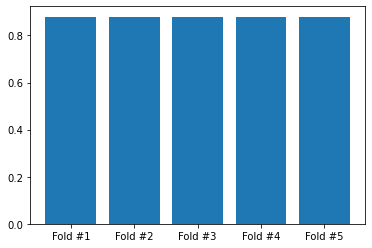

In [5]:
# evaluate
scores = cross_val_score(
    optimized_LGBM, 
    X_model, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True
                       ,random_state=100
                      ),
    scoring='roc_auc'
)
print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)

#0.8753111530570191
#0.8756329404995423
#0.8780611462672319 when iterate 10 times
#0.8786665892827801 when iterate 100 times

In [6]:
X_exam = pd.read_csv('X_exam.csv')
X_exam = preprocess(X_exam)

In [12]:
Y_exam = np.zeros(X_exam.shape[0])
k = 5
kf = StratifiedKFold(n_splits=k)
for tr_index, val_index in kf.split(X_model,Y_model):
    X_tr,Y_tr = X_model.iloc[tr_index],Y_model.iloc[tr_index]
    X_val, Y_val = X_model.iloc[val_index],Y_model.iloc[val_index]
    
    optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc',eval_set=[(X_tr,Y_tr),(X_val,Y_val)])
    proba = optimized_LGBM.predict_proba(X_exam)[:,1]
    Y_exam = Y_exam + proba
Y_exam = Y_exam/k
threshold = np.array([0.5,0.7,0.75,0.76,0.77,0.78,0.79,0.8,0.9])
# the ratio of high prob with different threshold
for num in threshold: 
    filtered = Y_exam[np.where(Y_exam>num)]
    print("the number of probability more than %.2f is %d:" %(num,len(filtered)))
    print("the ratio of probability more than %.2f is : %.4f"%(num, float(len(filtered))/len(Y_exam)))
    print('---------------------------------------------------')
# res = pd.DataFrame({'business prob':Y_exam})
# res.to_csv("./part1.csv")

[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] lambda_l1 is set=7.605903098612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.605903098612777
[LightGBM] [Warning] bagging_fraction is set=0.5924690776011455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5924690776011455
[LightGBM] [Warning] lambda_l2 is set=6.537583337749926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.537583337749926
[1]	training's auc: 0.867948	valid_1's auc: 0.867108
[2]	training's auc: 0.871538	valid_1's auc: 0.87011
[3]	training's auc: 0.873101	valid_1's auc: 0.871613
[4]	training's auc: 0.874399	valid_1's auc: 0.872569
[5]	training's auc: 0.87483	valid_1's auc: 0.872938
[6]	training's auc: 0.875367	valid_1's auc: 0.873366
[7]	training's auc: 0.876104	valid_1's auc: 0.873864
[8]	training's auc: 0.876544	valid_1's auc: 0.874041
[9]	training's auc: 0.876964	valid_1's auc: 

[34]	training's auc: 0.88455	valid_1's auc: 0.875014
[35]	training's auc: 0.88485	valid_1's auc: 0.875036
[36]	training's auc: 0.885029	valid_1's auc: 0.87506
[37]	training's auc: 0.885273	valid_1's auc: 0.875135
[38]	training's auc: 0.885541	valid_1's auc: 0.875203
[39]	training's auc: 0.885832	valid_1's auc: 0.875299
[40]	training's auc: 0.885979	valid_1's auc: 0.875323
[41]	training's auc: 0.886218	valid_1's auc: 0.875383
[42]	training's auc: 0.886414	valid_1's auc: 0.875415
[43]	training's auc: 0.886612	valid_1's auc: 0.875464
[44]	training's auc: 0.886901	valid_1's auc: 0.875557
[45]	training's auc: 0.887053	valid_1's auc: 0.875606
[46]	training's auc: 0.887272	valid_1's auc: 0.87566
[47]	training's auc: 0.887421	valid_1's auc: 0.875692
[48]	training's auc: 0.887563	valid_1's auc: 0.875703
[49]	training's auc: 0.887731	valid_1's auc: 0.87573
[50]	training's auc: 0.88786	valid_1's auc: 0.875797
[51]	training's auc: 0.887974	valid_1's auc: 0.875826
[52]	training's auc: 0.888116	vali

[77]	training's auc: 0.891938	valid_1's auc: 0.878258
[78]	training's auc: 0.892197	valid_1's auc: 0.878311
[79]	training's auc: 0.892287	valid_1's auc: 0.878336
[80]	training's auc: 0.892401	valid_1's auc: 0.878349
[81]	training's auc: 0.892539	valid_1's auc: 0.878363
[82]	training's auc: 0.892891	valid_1's auc: 0.878402
[83]	training's auc: 0.893021	valid_1's auc: 0.878408
[84]	training's auc: 0.893208	valid_1's auc: 0.878422
[85]	training's auc: 0.893364	valid_1's auc: 0.878423
[86]	training's auc: 0.893718	valid_1's auc: 0.878436
[87]	training's auc: 0.893871	valid_1's auc: 0.878477
[88]	training's auc: 0.893982	valid_1's auc: 0.878494
[89]	training's auc: 0.894082	valid_1's auc: 0.878497
[90]	training's auc: 0.894324	valid_1's auc: 0.878496
[91]	training's auc: 0.894437	valid_1's auc: 0.878524
[92]	training's auc: 0.894605	valid_1's auc: 0.878546
[93]	training's auc: 0.894863	valid_1's auc: 0.87855
[94]	training's auc: 0.894949	valid_1's auc: 0.878548
[95]	training's auc: 0.895125

[11]	training's auc: 0.877563	valid_1's auc: 0.877171
[12]	training's auc: 0.877833	valid_1's auc: 0.877366
[13]	training's auc: 0.878043	valid_1's auc: 0.877489
[14]	training's auc: 0.878326	valid_1's auc: 0.87759
[15]	training's auc: 0.87856	valid_1's auc: 0.877714
[16]	training's auc: 0.878798	valid_1's auc: 0.877744
[17]	training's auc: 0.879021	valid_1's auc: 0.877812
[18]	training's auc: 0.879308	valid_1's auc: 0.877976
[19]	training's auc: 0.879663	valid_1's auc: 0.878071
[20]	training's auc: 0.879929	valid_1's auc: 0.878119
[21]	training's auc: 0.880266	valid_1's auc: 0.878263
[22]	training's auc: 0.880568	valid_1's auc: 0.878438
[23]	training's auc: 0.880781	valid_1's auc: 0.878521
[24]	training's auc: 0.881037	valid_1's auc: 0.878559
[25]	training's auc: 0.881392	valid_1's auc: 0.878642
[26]	training's auc: 0.881658	valid_1's auc: 0.87876
[27]	training's auc: 0.882034	valid_1's auc: 0.878833
[28]	training's auc: 0.882267	valid_1's auc: 0.878905
[29]	training's auc: 0.882545	v

In [8]:
# references
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# http://devdoc.net/bigdata/LightGBM-doc-2.2.2/Parallel-Learning-Guide.html
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://www.kaggle.com/code/rmiperrier/tps-mar-lgbm-predict-proba-vs-predict/notebook
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://www.kaggle.com/code/kageyama/predict-by-lightgbm
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html